In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm



In [4]:
REBUILD_DATA = True

class DogsVsCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label,f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img),np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    print(str(e))
                    pass

        np.random.shuffle(self.training_data)
        np.save('training_data.npy', self.training_data)
        print("Cats:", self.dogcount)
        print("Dogs:", self.dogcount)

if REBUILD_DATA:
    dogsvscats = DogsVsCats()
    dogsvscats.make_training_data()

100%|██████████| 12501/12501 [00:15<00:00, 804.58it/s]
/home/starksultana/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


PetImages/Cat
OpenCV(4.5.1) /tmp/pip-req-build-ms668fyv/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.1) /tmp/pip-req-build-ms668fyv/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.1) /tmp/pip-req-build-ms668fyv/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.1) /tmp/pip-req-build-ms668fyv/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.1) /tmp/pip-req-build-ms668fyv/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.1) /tmp/pip-req-build-ms668fyv/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.1) /tmp/pip-req-build-ms668fyv/opencv/modules/imgpr

In [5]:
training_data = np.load('training_data.npy', allow_pickle = True)
print(len(training_data))


24946


In [6]:
print(training_data[1])


[array([[107, 104, 105, ...,  83,  88,  89],
       [115, 108, 109, ...,  90, 109, 106],
       [103, 100, 123, ...,  70,  83,  92],
       ...,
       [ 89,  84,  85, ...,  86,  89,  62],
       [ 86,  83,  80, ...,  61,  39,  40],
       [ 79,  80,  79, ...,  52,  78,  33]], dtype=uint8)
 array([0., 1.])]


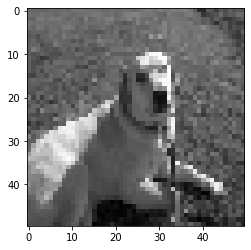

In [8]:
import matplotlib.pyplot as plt
plt.imshow(training_data[1][0], cmap = 'gray')
plt.show()

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim = 1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [13]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view( -1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)



2494


In [15]:
train_X = X[: -val_size]
train_y = y[: -val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

In [17]:
BATCH_SIZE = 100
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0,len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

print(loss)

100%|██████████| 225/225 [00:54<00:00,  4.10it/s]


tensor(0.2368, grad_fn=<MseLossBackward>)


In [18]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,50,50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1

print("Accuracy:", round(correct/total,3))

100%|██████████| 2494/2494 [00:06<00:00, 390.59it/s]


Accuracy: 0.593
